In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [78]:
def parse_nucleotides(sequence):
    new_seq = []
    map_to_vals = {"a": 1, "c": 2, "g": 3, "t":4}
    for symbol in sequence:
        new_seq.append(map_to_vals[symbol])
        
    return new_seq

def parse_val_to_nuc(seq):
    new_seq = []
    val_to_nuc = ["a", "c", "g", "t"]
    for val in seq:
        new_seq.append(val_to_nuc[int(val)-1])
    
    return new_seq

In [79]:
def getskmer(snippet, profile):
    spaced_kmer = snippet * profile
    spaced_kmer = spaced_kmer[spaced_kmer != 0]
    s = ''.join(str(x) for x in spaced_kmer)
    return s

In [429]:
def maxcount(pos, seqs, seqs_kmers, spaced_kmer_profile, seq_to_investigate=0):
    target = seqs[seq_to_investigate]
    f = len(spaced_kmer_profile)
    counts = []
    indexes = []
    end = min(pos+1, f)
    for i in range(end):
        '''
        if spaced_kmer_profile[f-i-1] != 1:# non-informative position
            counts.append(-1)
            indexes.append(-1)
            continue
        '''
        if spaced_kmer_profile[f-i-1] == 1:
            # Extract k mers starting at selected position
            s = getskmer(target[pos-i : pos-i+f], spaced_kmer_profile)
            counts.append(seqs_kmers[s])
            indexes.append(i)
    #counts.reverse()
    #indexes.reverse()
    return max(counts), indexes[np.argmax(counts)]

def fixed_maxcount(pos, seqs, seqs_kmers, spaced_kmer_profile, seq_to_investigate=0):
    target = seqs[seq_to_investigate]
    f = len(spaced_kmer_profile)
    counts_i = []
    indexes = []
    len_loop = min(f-1, pos)
    start = pos-len_loop
    end = pos+1
    for i in range(start, end):
        if spaced_kmer_profile[pos-i] != 1:
            counts_i.append(0)
            indexes.append(-1)
            continue
            
        # Extract k mers starting at selected position
        spaced_kmer = target[i : i+f] * spaced_kmer_profile
        spaced_kmer = spaced_kmer[spaced_kmer != 0]
        s = ''.join(str(x) for x in spaced_kmer)
        counts_i.append(seqs_kmers[s]) 
        indexes.append(i)
    
    return max(counts_i), indexes[np.argmax(counts_i)]

In [440]:
#
# CORRECT COUNTS - AN ATTEMPT AT FIXING THE ECLIPSE ERROR
#
def correct_counts(maxed_counts, mci, target_sequence, diff_profile, kmer_profile, starts, ends):
    f = len(kmer_profile)
    correction_artifact = []
    last_correction = 0 
    for i in range(0,len(diff_profile)):
        # Check for dip
        correction = 0
        if diff_profile[i] != 0: # This means that a read must've ended/started here or irregular position
            s1 = getskmer(target_sequence[i+1:i+f+1], kmer_profile)
            #print(parse_val_to_nuc(s2))
            if s1 in starts: correction -= starts[s1]
            #print("i;:"+str(i))
            if i >= f: 
                s2 = getskmer(target_sequence[i-f+1:i+1], kmer_profile)
                if s2 in ends:
                    correction += ends[s2]
            '''
            if np.abs(correction) > 1:
                print(s1)
                if s1 in starts: print("start here "+str(i)+": " + str(starts[s1]))
                print(s2)
                if s2 in ends: print("end here: " + str(ends[s2]))
                print(str(i) + ": ")
                print(maxed_counts[i-2:i+2])
            '''
            '''
            if i in [j for j in range(222, 250)]:
                s1 = getskmer(target_sequence[i:i+f], kmer_profile)
                if s1 in starts: print("start here "+str(i)+": " + str(starts[s1]))
                s2 = getskmer(target_sequence[i-f:i], kmer_profile)
                if s2 in ends: print("end here: " + str(ends[s2]))
                print(str(i) + ": ")
                print(maxed_counts[i-2:i+2])
                print("corr: " + str(correction))
            '''
        if correction != 0: correction_artifact.append([i, correction])
        diff_profile[i] += correction
        #maxed_counts[i] -= correction
        
    return diff_profile, correction_artifact

In [441]:
def correct2(filename, str_profile, seq_to_investigate):
    seqs = []
    with open(filename) as file_in:
        for line in file_in:
            newline = line.rstrip('\n')
            sequence_chars = [char for char in newline]
            sequence = parse_nucleotides(sequence_chars)
            seqs.append(np.array(sequence))
    
    profile = [int(character) for character in str_profile]
    k = sum(profile)
    f = len(profile)
    
    # Turn into np arrays for componentwise multiplication
    profile = np.array(profile)
    
    # Count occurence of spaced k-mers
    seqs_kmers = {}
    starts = {}
    ends = {}
    for sequence in seqs:
        for i in range(len(sequence) - f + 1):
            s = getskmer(sequence[i:i+f], profile)
            # For the count profiles
            if s not in seqs_kmers:
                seqs_kmers[s] = 1
            else:
                seqs_kmers[s] += 1
            # For collecting the start and end points
            if i == 0:
                #solid_s = getskmer(sequence[i:i+f], profile)
                if s not in starts:
                    starts[s] = 1
                else:
                    #print("duplicate at start: " + str(parse_val_to_nuc(solid_s)))
                    starts[s] += 1
            elif i == len(sequence)-f:
                #solid_s = getskmer(sequence[i:i+f], profile)
                if s not in ends:
                    ends[s] = 1
                else:
                    #print("duplicate at end: " + str(parse_val_to_nuc(solid_s)))
                    ends[s] += 1
    
    # Get maxcounts from counts
    target = seqs[seq_to_investigate]
    xpoints = np.array([i for i in range(len(target) - f + 1)])
    max_counts = []
    max_count_indices = []
    for i in range(len(target) - f + 1):
        maxp, argmaxp = maxcount(i, seqs, seqs_kmers, profile, seq_to_investigate=seq_to_investigate)
        max_counts.append(maxp)
        max_count_indices.append(argmaxp)
        if argmaxp == -1: print("M1!!!!")
    
    # Get diff profile:
    pre_corr_diff_profile = [max_counts[j] - max_counts[j-1] for j in range(1,len(max_counts))]
    
    # Apply correction strategy
    ypoints, correction_artifact = correct_counts(max_counts.copy(), max_count_indices, target, pre_corr_diff_profile.copy(), profile, starts, ends)
    
    return xpoints[1:], ypoints, max_counts, pre_corr_diff_profile, correction_artifact, max_count_indices

## Test

[[48, 1], [106, 1], [148, 1]]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 4, 5, 6, 8, 8, 9, 11, 11, 13, 13, 15, 15, 16, 17, 19, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 4, 5, 6, 8, 8, 9, 11, 11, 13, 13, 15, 15, 16, 17, 19, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 4, 5, 

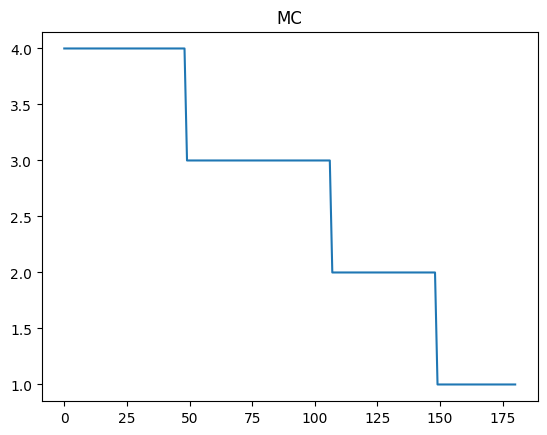

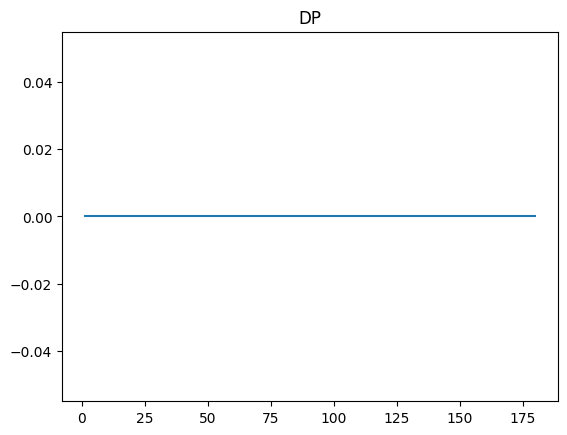

In [442]:
xpoints, ypoints, mc, diff_p, artifact, mci = correct2("data/simplest.txt", "10111010101101110111", 3)
#print(se)
print(artifact)
print(mc)
print(mci)
# Plot
plt.title("MC")
plt.plot([i for i in range(len(mc))], mc)
plt.show()
# Plot
plt.title("DP")
plt.plot(xpoints, ypoints)
plt.show()

[[30, -1], [107, -1], [147, -1]]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

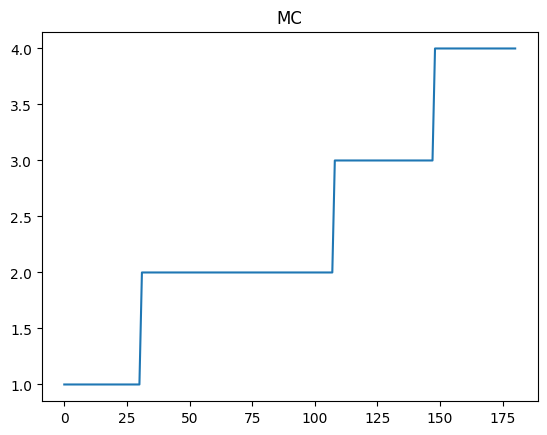

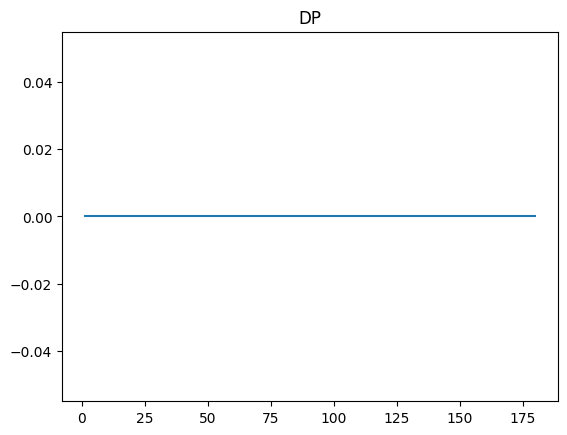

In [443]:
xpoints, ypoints, mc, diff_p, artifact, mci = correct2("data/simplest2.txt", "10111010101101110111", 0)
#print(se)
print(artifact)
print(mc)
print(mci)
# Plot
plt.title("MC")
plt.plot([i for i in range(len(mc))], mc)
plt.show()
# Plot
plt.title("DP")
plt.plot(xpoints, ypoints)
plt.show()

[[11, -2], [30, -2], [80, 2], [116, 1]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 4, 5, 6, 8, 8, 9, 11, 11, 13, 13, 15, 15, 16, 17, 19, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 4, 5, 6, 8, 8, 9, 11, 11, 13, 13, 15, 15, 16, 17, 19, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

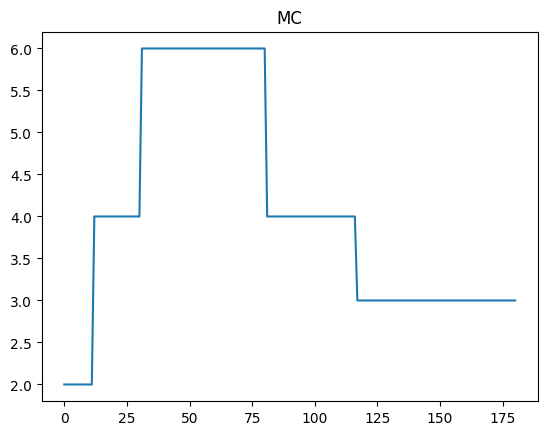

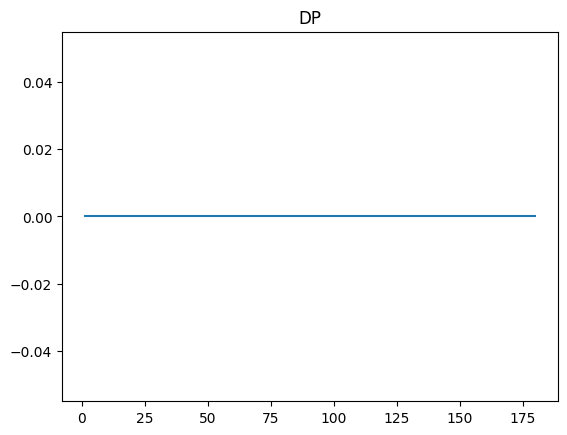

In [444]:
xpoints, ypoints, mc, diff_p, artifact, mci = correct2("data/simplest3.txt", "10111010101101110111", 0)
#print(se)
print(artifact)
print(mc)
print(mci)
# Plot
plt.title("MC")
plt.plot([i for i in range(len(mc))], mc)
plt.show()
# Plot
plt.title("DP")
plt.plot(xpoints, ypoints)
plt.show()

## Random reads from 3000 length genome

[[4, -1], [26, -1], [28, -1], [64, -1], [124, 2]]


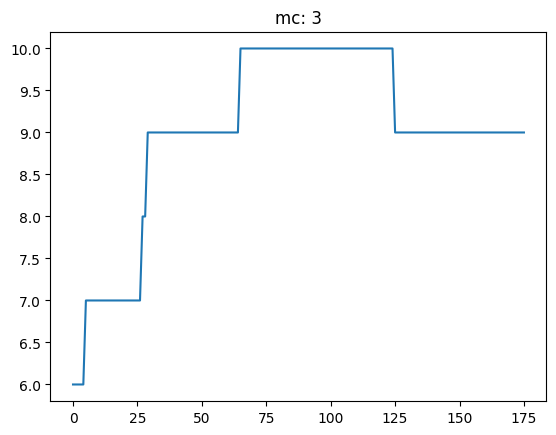

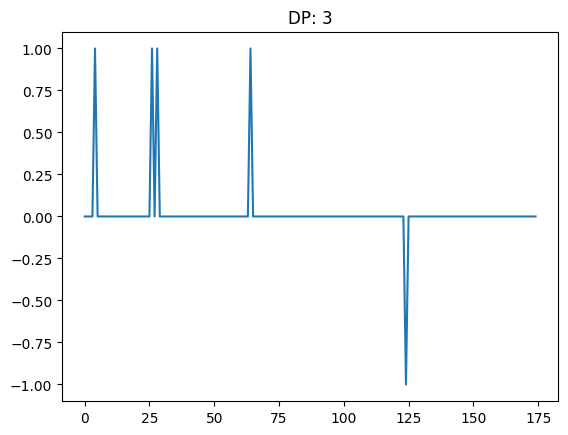

[4, 26, 28, 64, 124]


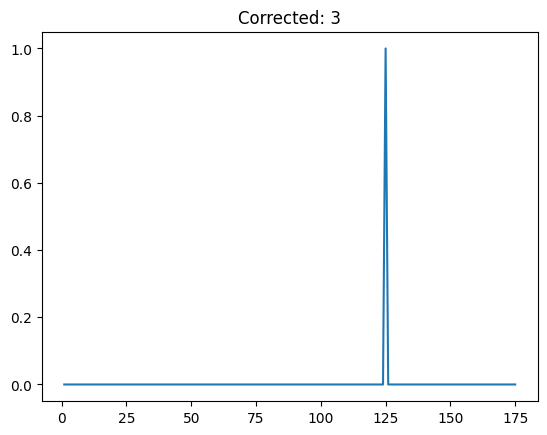

[124]
[[13, -1], [19, -1], [25, -1], [59, -1], [92, 1], [97, 1], [102, 1], [103, -1], [146, 1], [156, -1]]


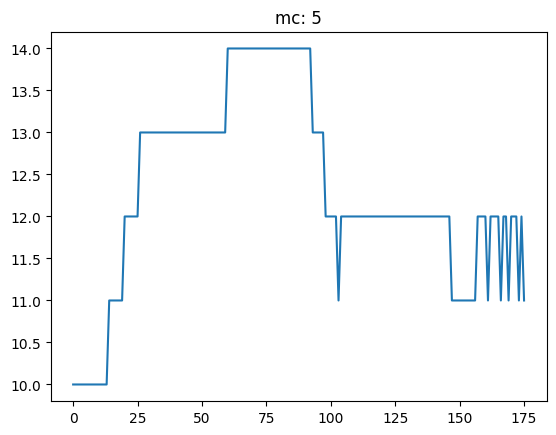

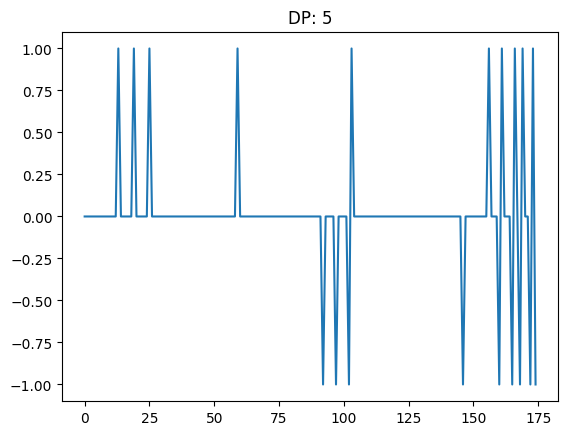

[13, 19, 25, 59, 92, 97, 102, 103, 146, 156, 160, 161, 165, 166, 168, 169, 172, 173, 174]


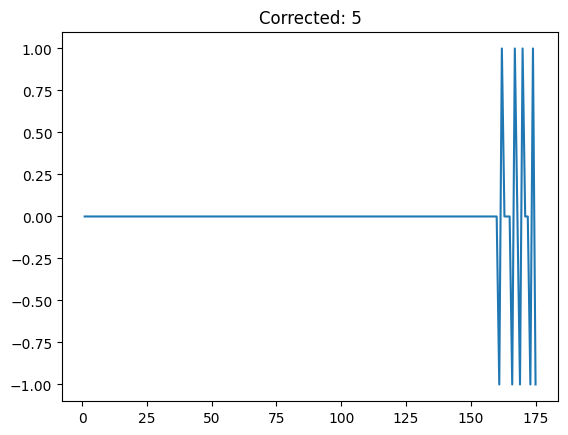

[160, 161, 165, 166, 168, 169, 172, 173, 174]
[[4, -1], [50, 1], [73, -1], [133, 1], [147, 1], [154, 1], [160, -2]]


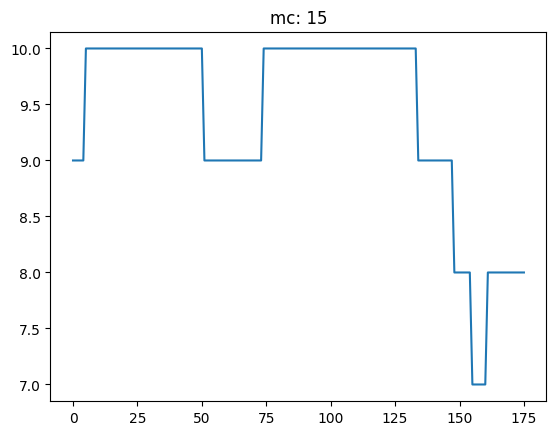

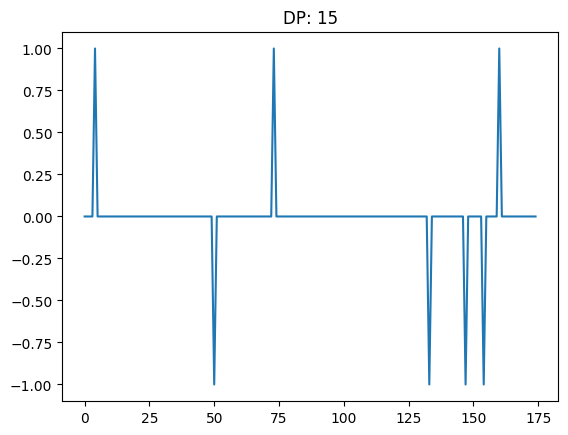

[4, 50, 73, 133, 147, 154, 160]


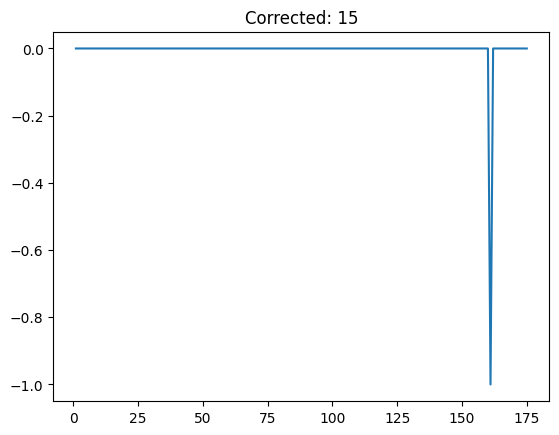

[160]
[[59, 2], [115, 1], [134, 1], [139, 1]]


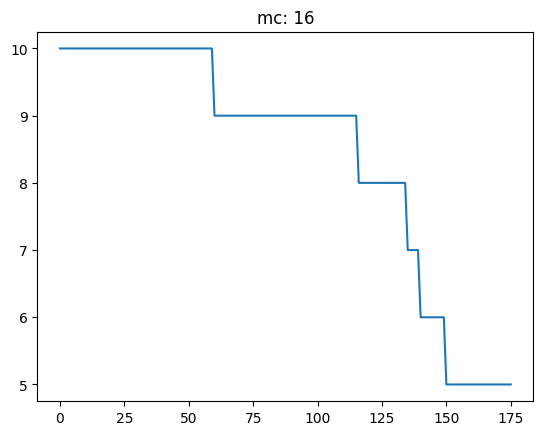

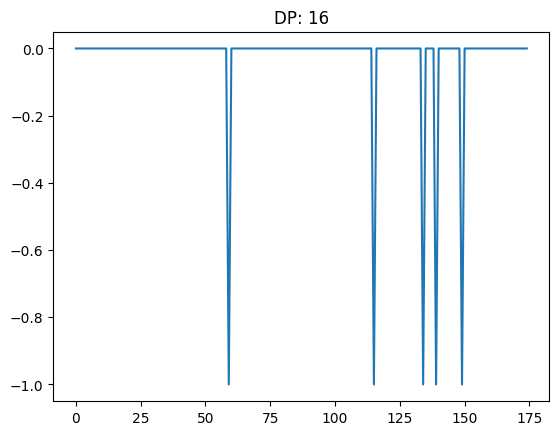

[59, 115, 134, 139, 149]


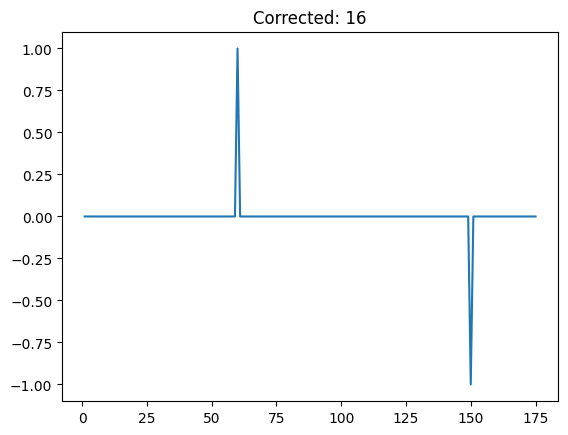

[59, 149]
[[2, -1], [7, -1], [53, 1], [76, -1], [136, 1], [150, 1], [157, 1], [163, -2]]


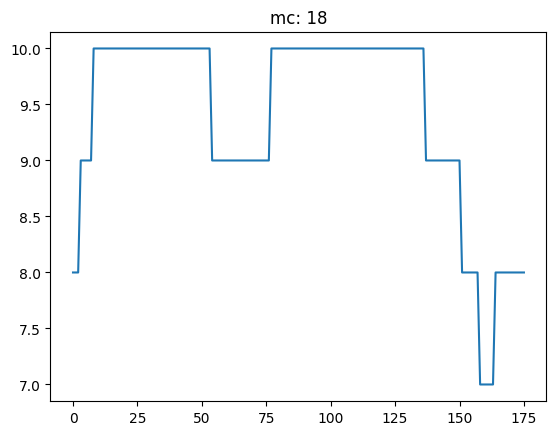

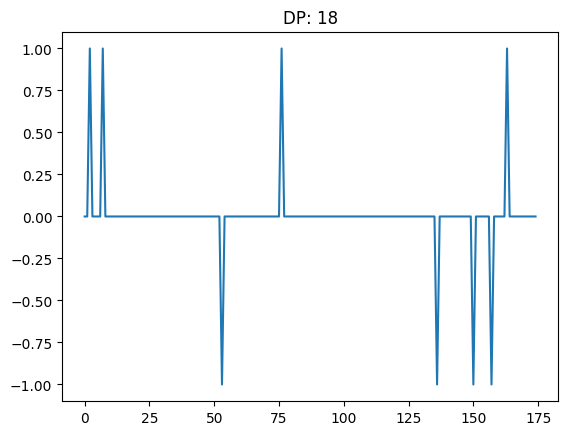

[2, 7, 53, 76, 136, 150, 157, 163]


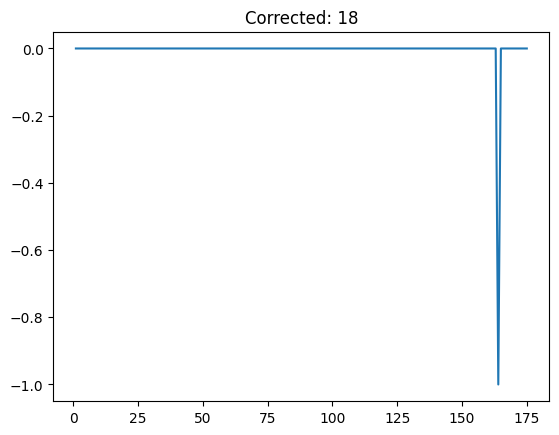

[163]
[[33, -1], [66, 1], [71, 1], [76, 1], [77, -1], [120, 1], [130, -1], [155, 1], [160, 1], [168, 1], [172, 1], [173, 1]]


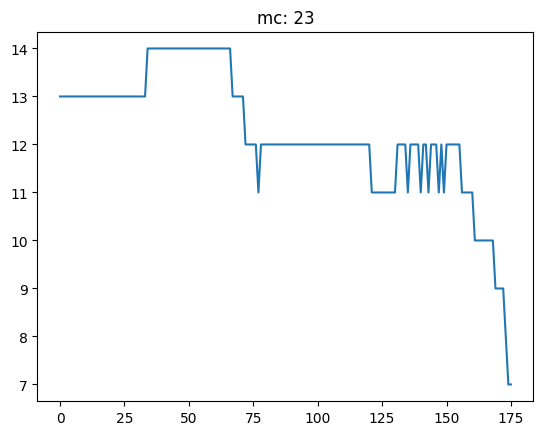

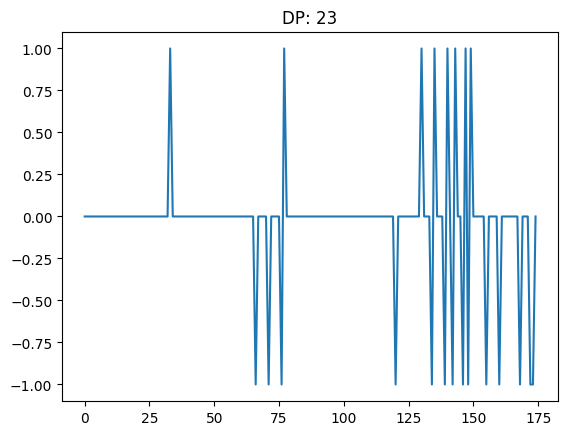

[33, 66, 71, 76, 77, 120, 130, 134, 135, 139, 140, 142, 143, 146, 147, 148, 149, 155, 160, 168, 172, 173]


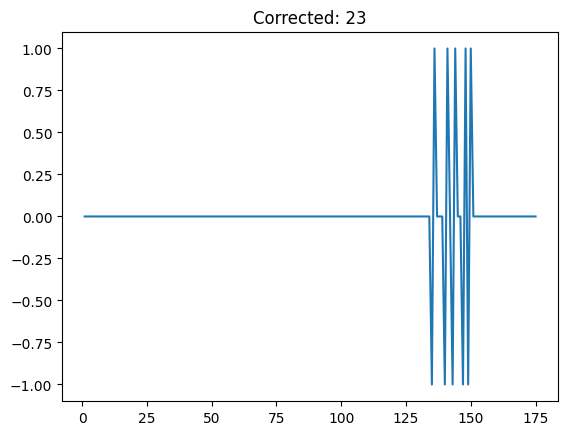

[134, 135, 139, 140, 142, 143, 146, 147, 148, 149]
[[59, 1], [73, 1], [80, 1], [86, -2], [122, 1], [125, 1], [126, 1], [130, 1], [142, -1], [161, -1], [166, -1]]


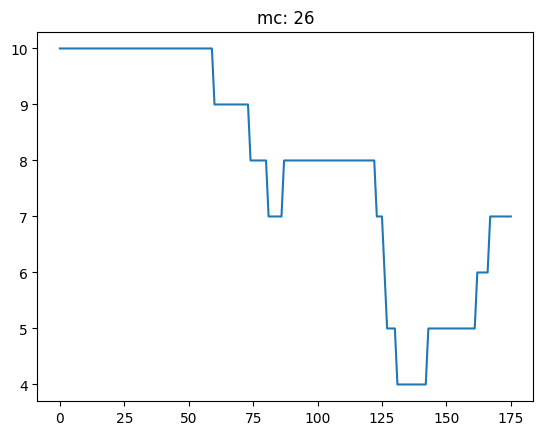

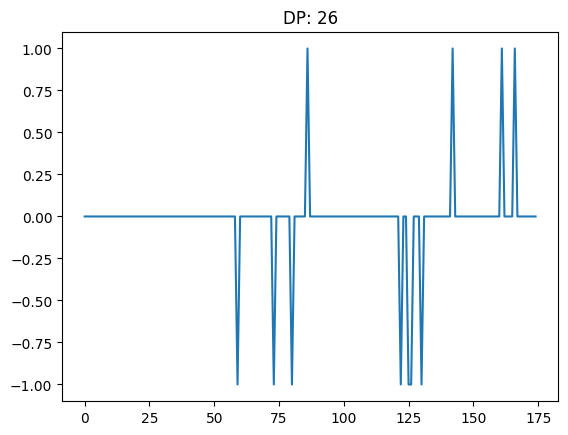

[59, 73, 80, 86, 122, 125, 126, 130, 142, 161, 166]


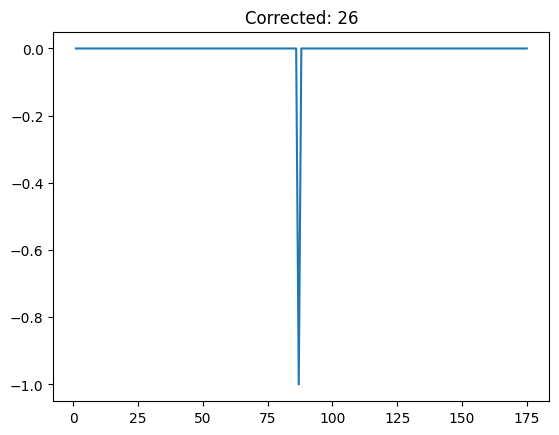

[86]
[[13, -1], [38, 1], [39, -1], [82, 1], [136, -1], [143, -1]]


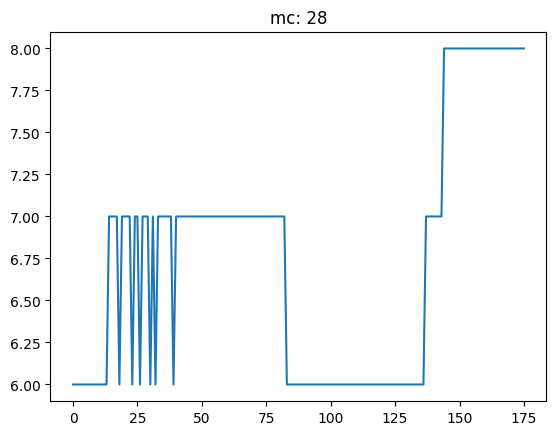

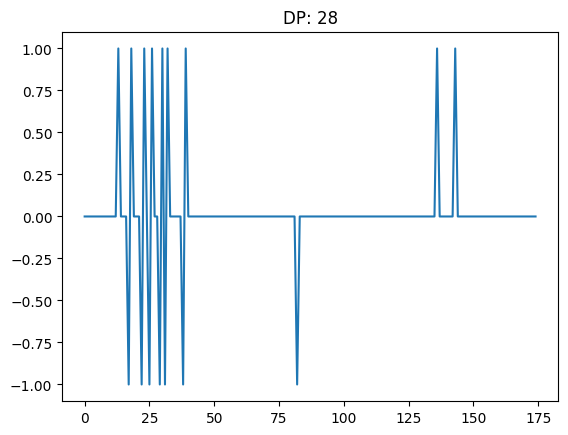

[13, 17, 18, 22, 23, 25, 26, 29, 30, 31, 32, 38, 39, 82, 136, 143]


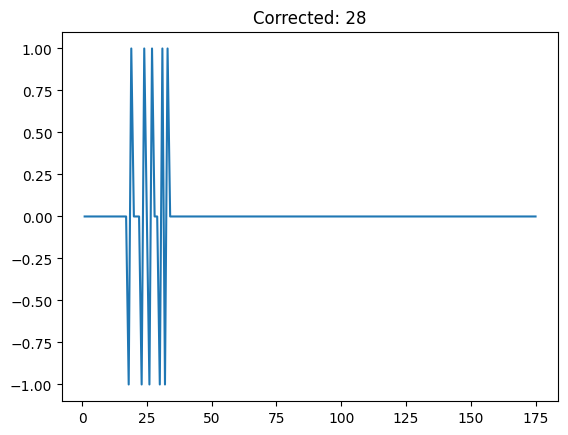

[17, 18, 22, 23, 25, 26, 29, 30, 31, 32]
[[21, -1], [23, -1], [59, -1], [119, 2]]


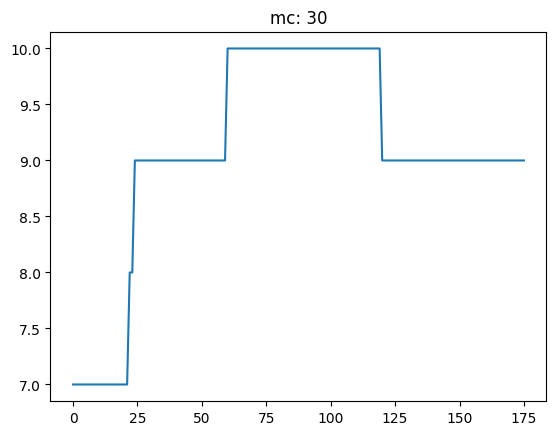

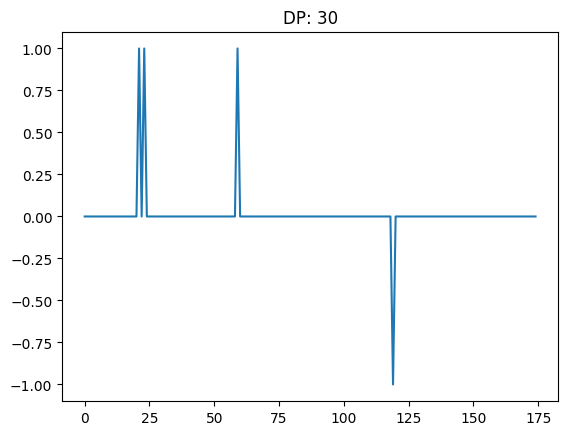

[21, 23, 59, 119]


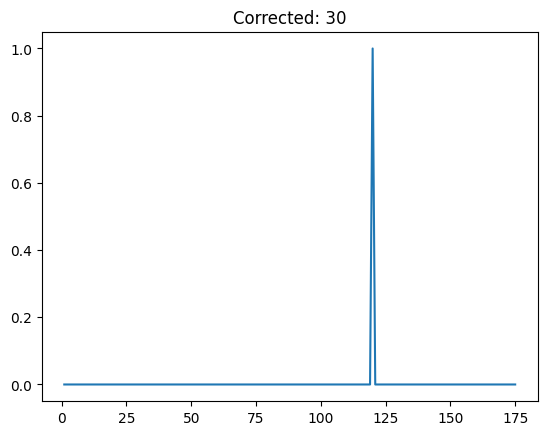

[119]
[[3, -1], [4, -1], [18, -1], [24, -1], [30, -1], [64, -1], [97, 1], [102, 1], [107, 1], [108, -1], [151, 1], [161, -1]]


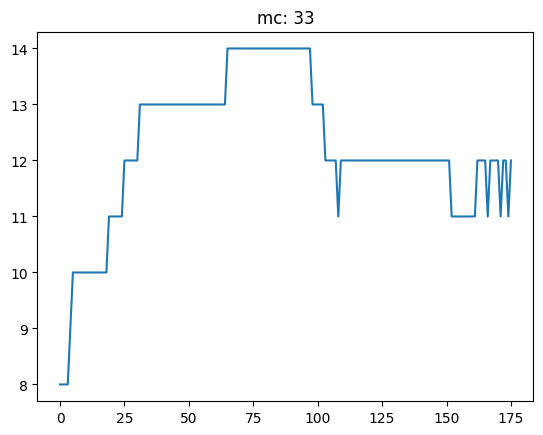

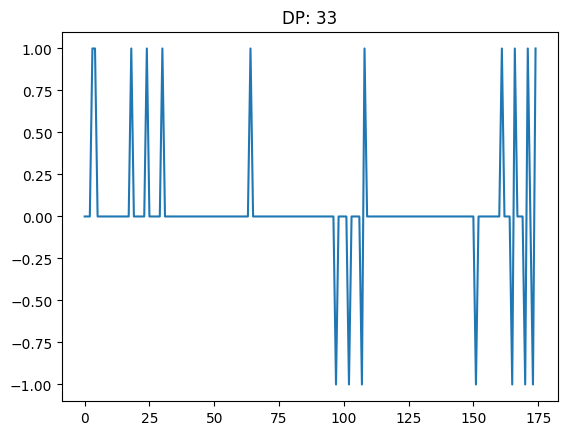

[3, 4, 18, 24, 30, 64, 97, 102, 107, 108, 151, 161, 165, 166, 170, 171, 173, 174]


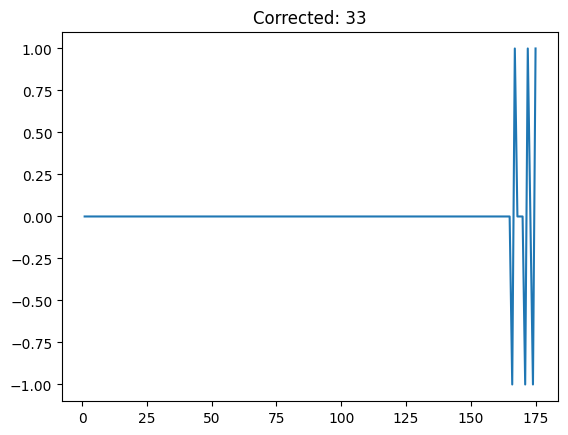

[165, 166, 170, 171, 173, 174]
[[33, 1], [39, -1], [47, -1], [51, -1], [52, -1], [66, -1], [72, -1], [78, -1], [112, -1], [145, 1], [150, 1], [155, 1], [156, -1]]


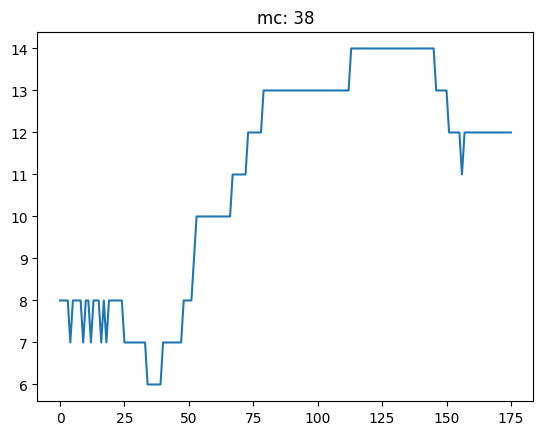

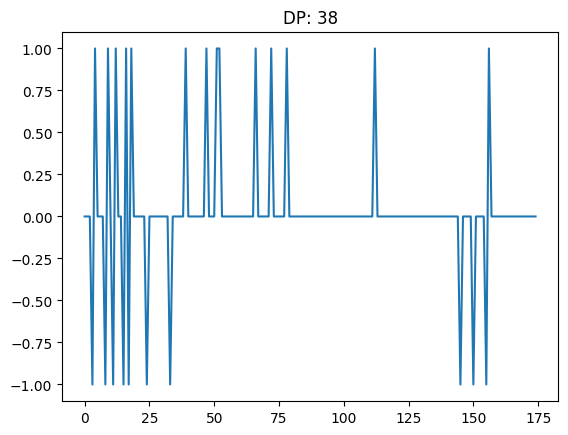

[3, 4, 8, 9, 11, 12, 15, 16, 17, 18, 24, 33, 39, 47, 51, 52, 66, 72, 78, 112, 145, 150, 155, 156]


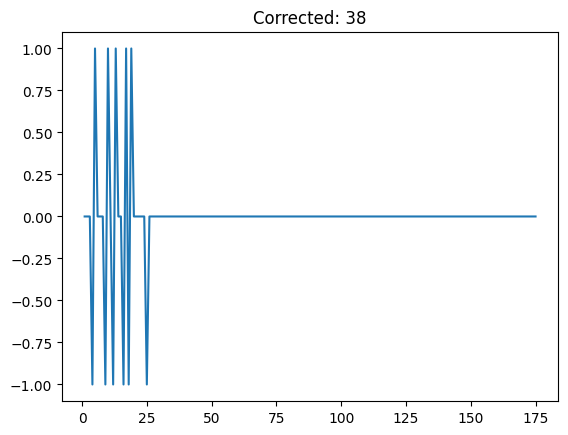

[3, 4, 8, 9, 11, 12, 15, 16, 17, 18, 24]
[[25, -1], [68, 1], [122, -1], [129, -1], [174, -1]]


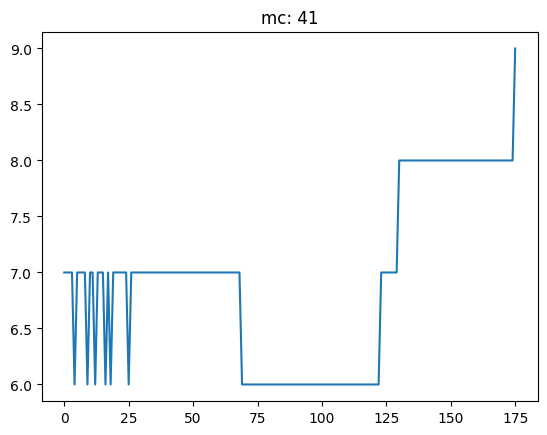

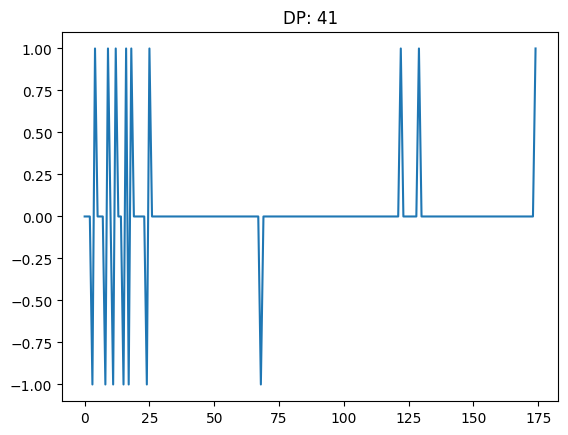

[3, 4, 8, 9, 11, 12, 15, 16, 17, 18, 24, 25, 68, 122, 129, 174]


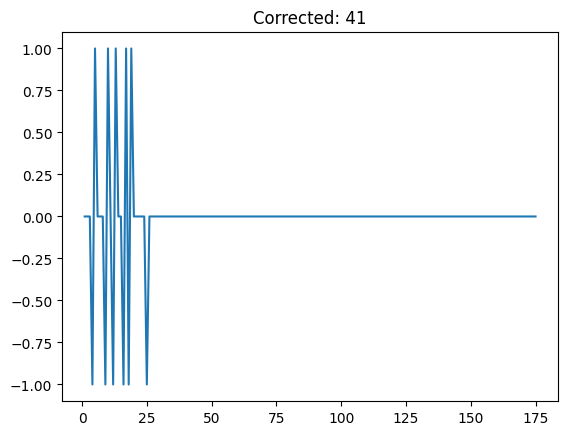

[3, 4, 8, 9, 11, 12, 15, 16, 17, 18, 24]
[[32, 1], [37, 1], [42, 1], [43, -1], [86, 1], [96, -1], [121, 1], [126, 1], [134, 1], [138, 1], [139, 1], [153, 1], [159, 1], [160, -1], [174, -1]]


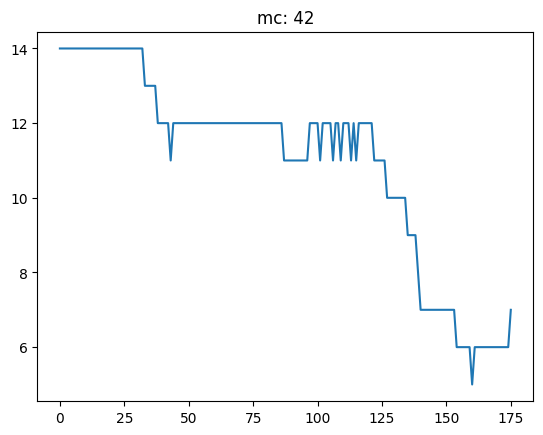

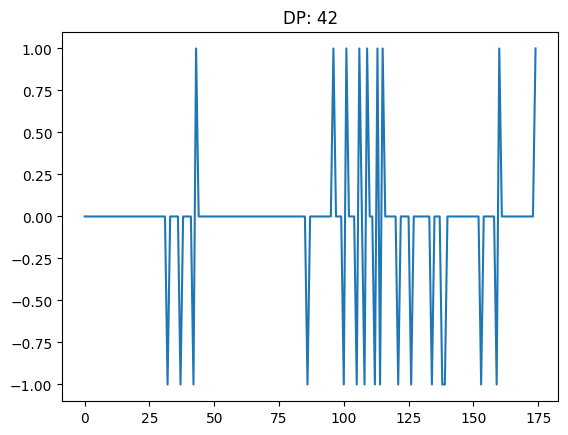

[32, 37, 42, 43, 86, 96, 100, 101, 105, 106, 108, 109, 112, 113, 114, 115, 121, 126, 134, 138, 139, 153, 159, 160, 174]


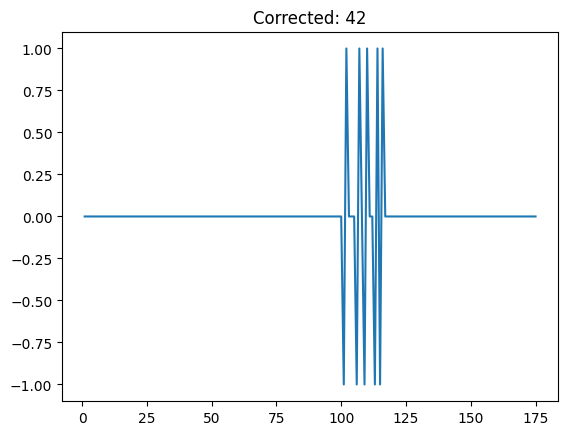

[100, 101, 105, 106, 108, 109, 112, 113, 114, 115]
[[45, 1], [68, -1], [128, 1], [142, 1], [149, 1], [155, -2]]


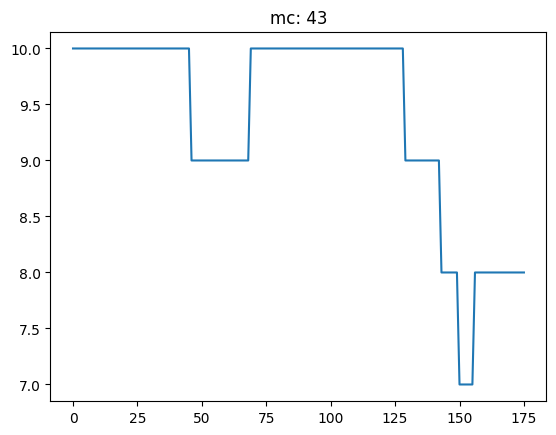

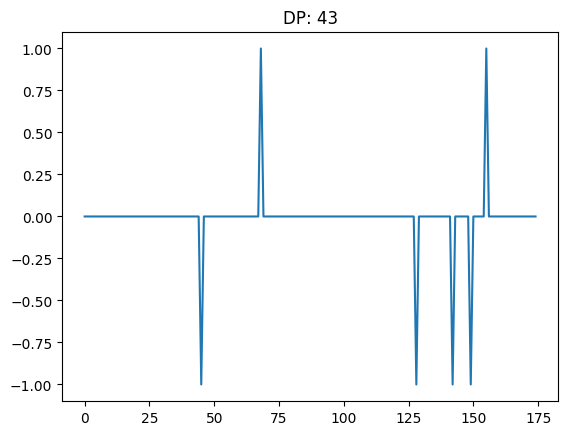

[45, 68, 128, 142, 149, 155]


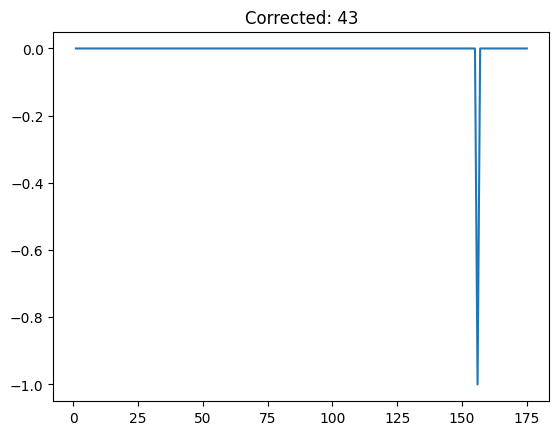

[155]
[[7, -1], [11, -1], [12, -1], [26, -1], [32, -1], [38, -1], [72, -1], [105, 1], [110, 1], [115, 1], [116, -1], [159, 1], [169, -1]]


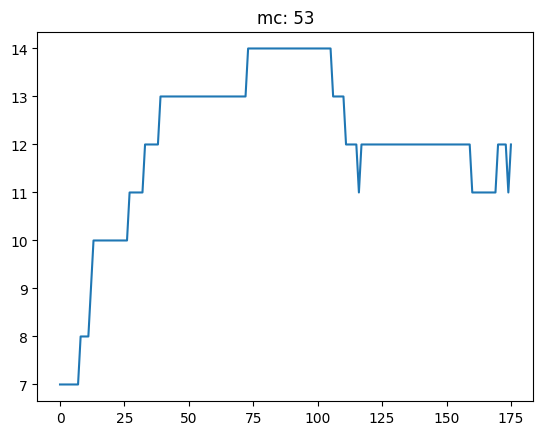

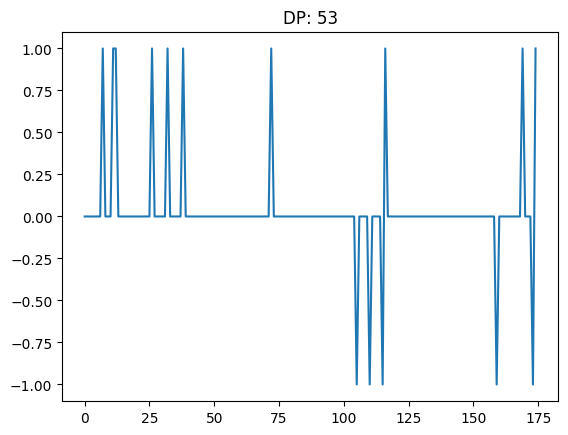

[7, 11, 12, 26, 32, 38, 72, 105, 110, 115, 116, 159, 169, 173, 174]


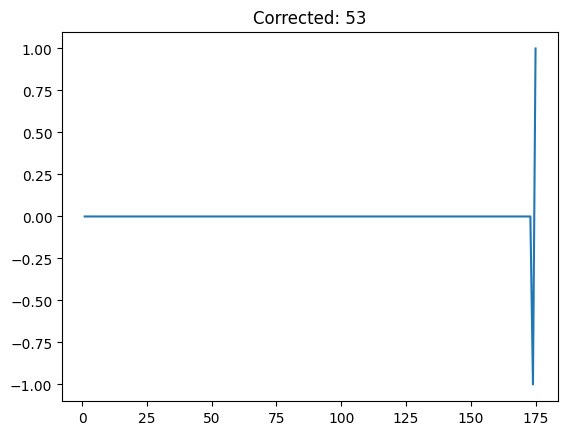

[173, 174]
[[42, 1], [52, -1], [77, 1], [82, 1], [90, 1], [94, 1], [95, 1], [109, 1], [115, 1], [116, -1], [130, -1], [155, 1], [156, -1]]


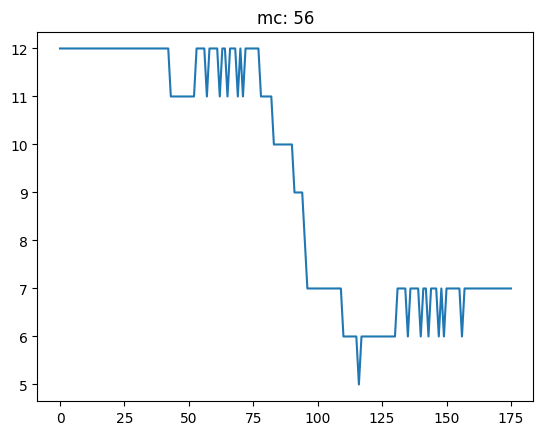

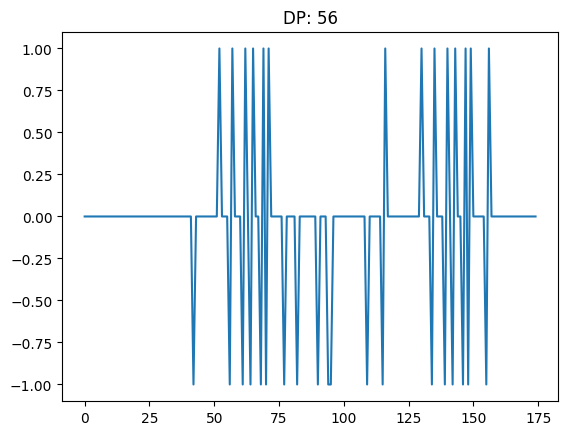

[42, 52, 56, 57, 61, 62, 64, 65, 68, 69, 70, 71, 77, 82, 90, 94, 95, 109, 115, 116, 130, 134, 135, 139, 140, 142, 143, 146, 147, 148, 149, 155, 156]


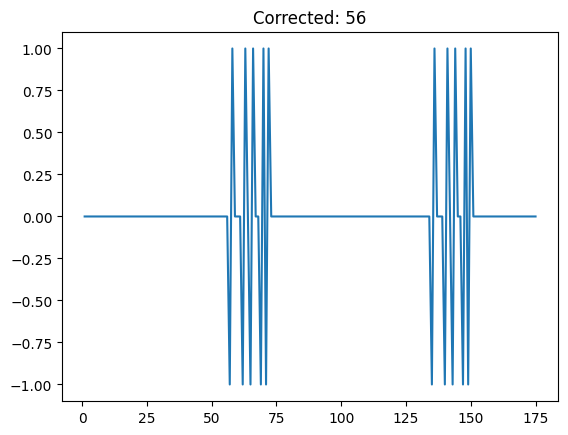

[56, 57, 61, 62, 64, 65, 68, 69, 70, 71, 134, 135, 139, 140, 142, 143, 146, 147, 148, 149]
[[29, 1], [37, 1], [41, 1], [42, 1], [56, 1], [62, 1], [63, -1], [77, -1], [102, 1], [103, -1], [146, 1]]


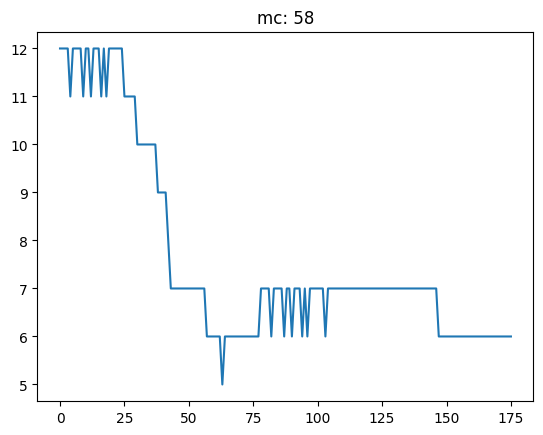

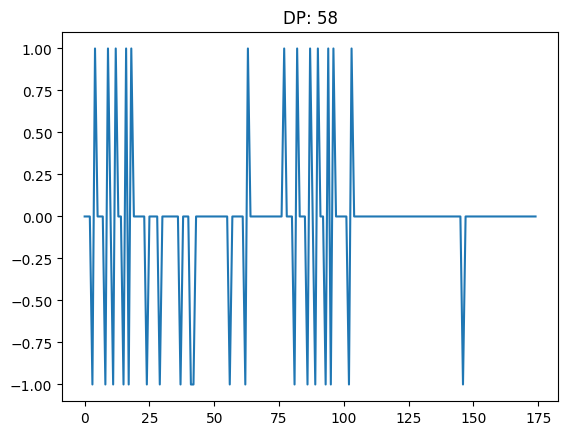

[3, 4, 8, 9, 11, 12, 15, 16, 17, 18, 24, 29, 37, 41, 42, 56, 62, 63, 77, 81, 82, 86, 87, 89, 90, 93, 94, 95, 96, 102, 103, 146]


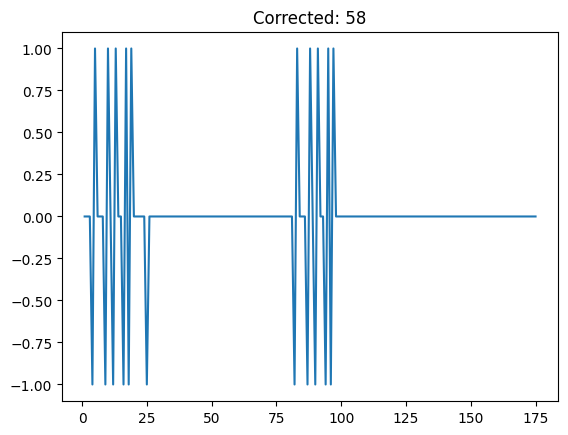

[3, 4, 8, 9, 11, 12, 15, 16, 17, 18, 24, 81, 82, 86, 87, 89, 90, 93, 94, 95, 96]
[[5, -1], [39, -1], [72, 1], [77, 1], [82, 1], [83, -1], [126, 1], [136, -1], [161, 1], [166, 1], [174, 1]]


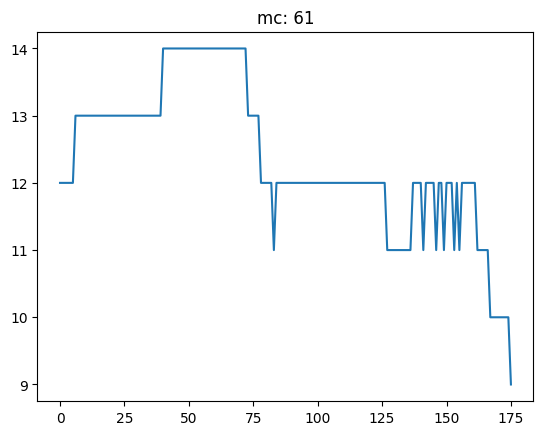

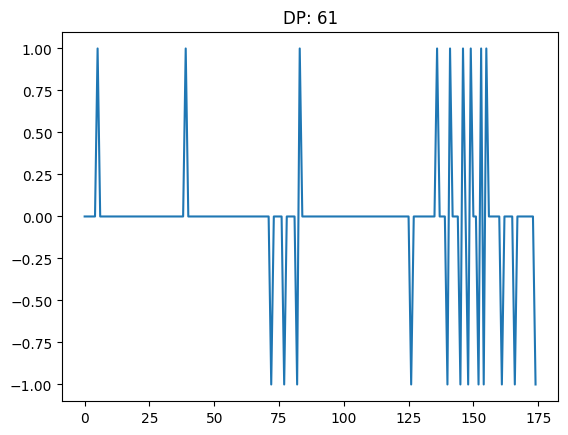

[5, 39, 72, 77, 82, 83, 126, 136, 140, 141, 145, 146, 148, 149, 152, 153, 154, 155, 161, 166, 174]


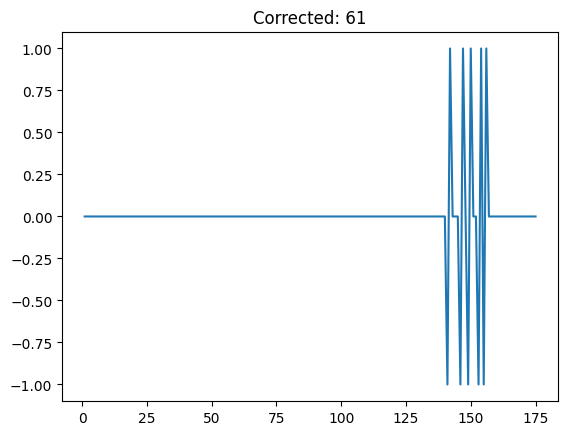

[140, 141, 145, 146, 148, 149, 152, 153, 154, 155]
[[0, -1], [14, -1], [20, -1], [26, -1], [60, -1], [93, 1], [98, 1], [103, 1], [104, -1], [147, 1], [157, -1]]


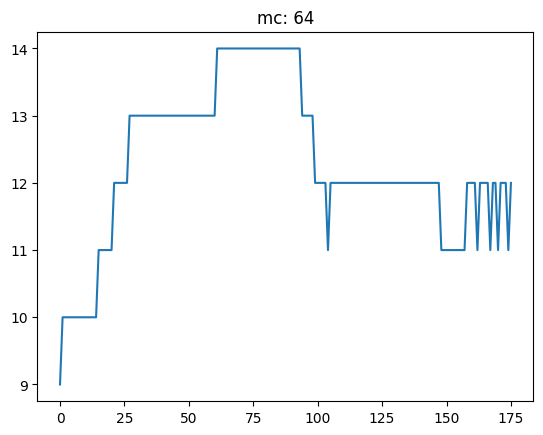

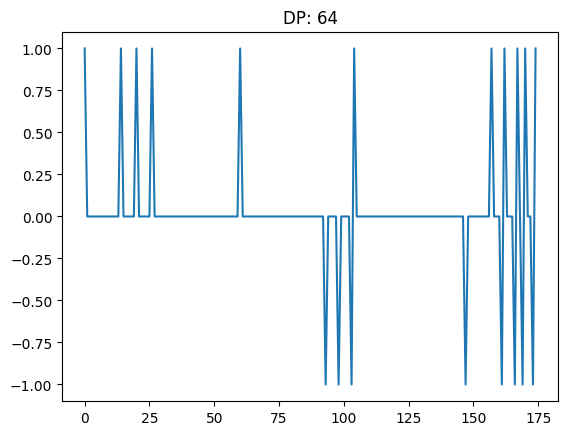

[0, 14, 20, 26, 60, 93, 98, 103, 104, 147, 157, 161, 162, 166, 167, 169, 170, 173, 174]


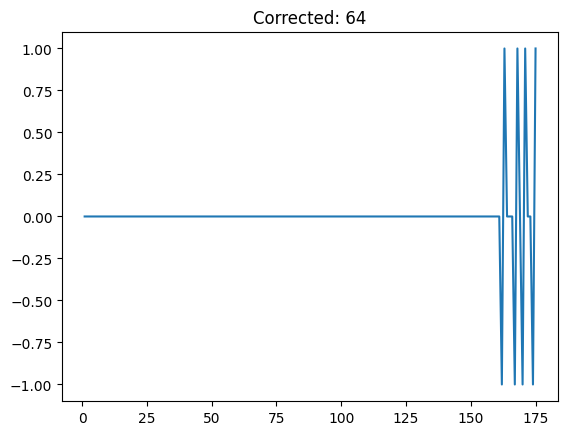

[161, 162, 166, 167, 169, 170, 173, 174]
[[14, -1], [28, -1], [53, 1], [54, -1], [97, 1], [151, -1], [158, -1]]


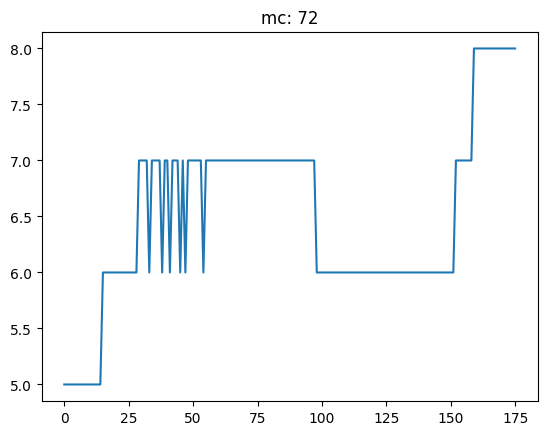

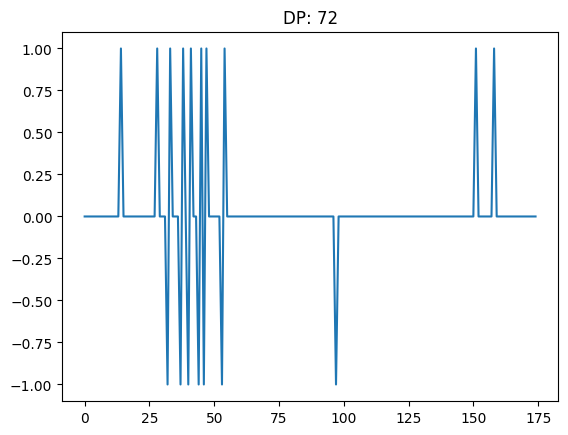

[14, 28, 32, 33, 37, 38, 40, 41, 44, 45, 46, 47, 53, 54, 97, 151, 158]


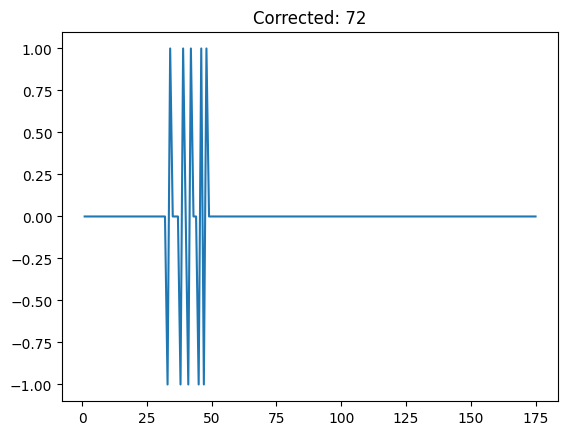

[32, 33, 37, 38, 40, 41, 44, 45, 46, 47]
[[11, -1], [13, -1], [49, -1], [109, 2], [165, 1]]


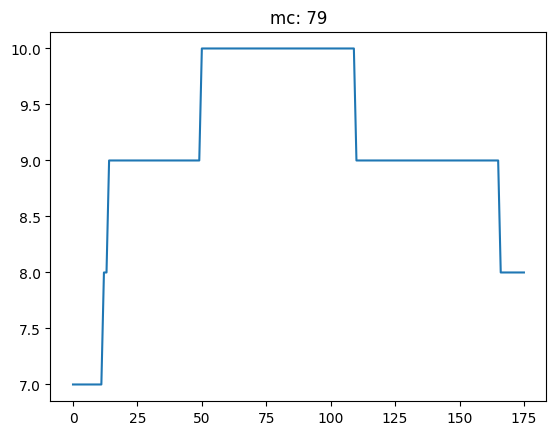

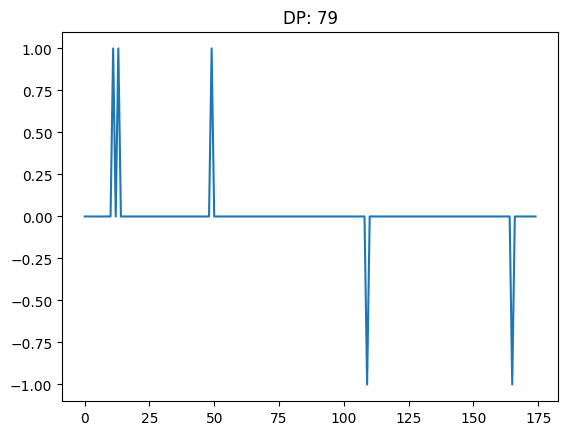

[11, 13, 49, 109, 165]


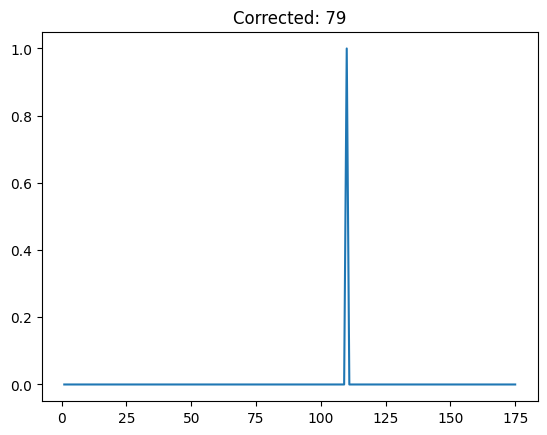

[109]
[[58, 1], [77, 1], [82, 1]]


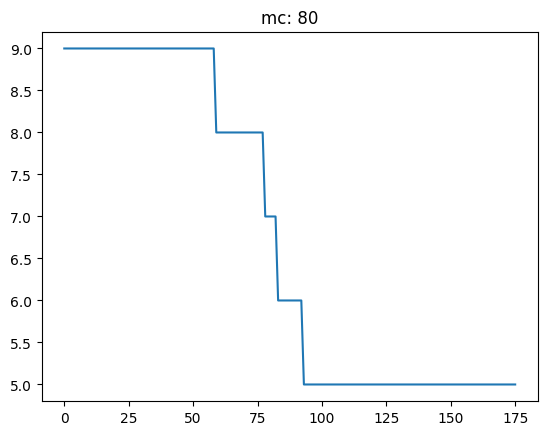

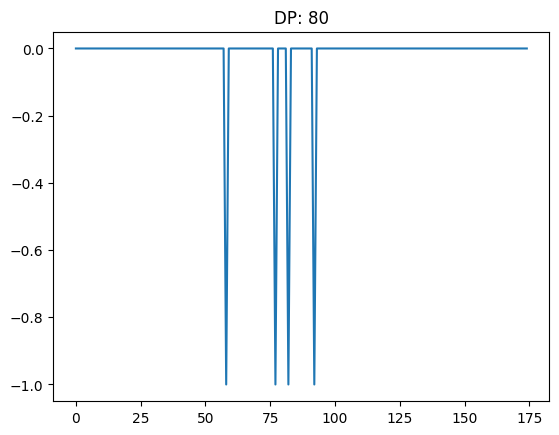

[58, 77, 82, 92]


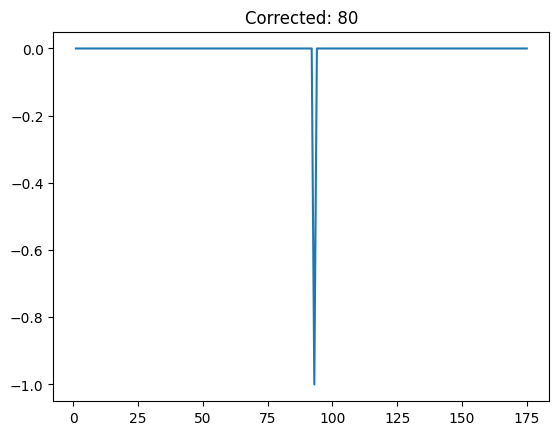

[92]
[[5, -1], [11, -1], [45, -1], [78, 1], [83, 1], [88, 1], [89, -1], [132, 1], [142, -1], [167, 1], [172, 1]]


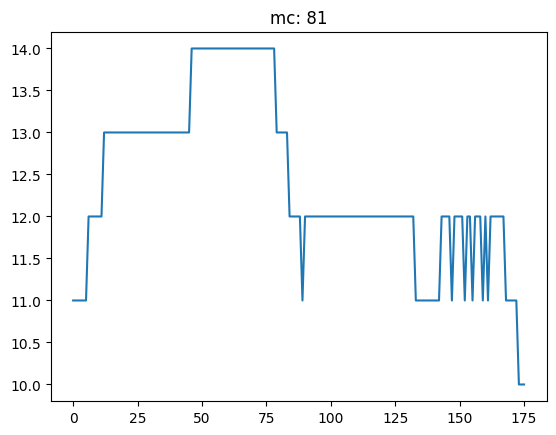

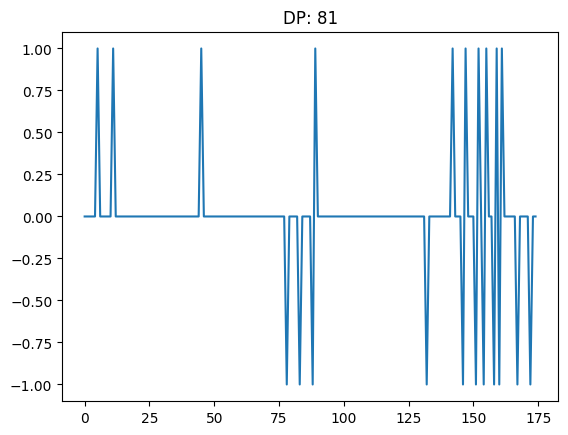

[5, 11, 45, 78, 83, 88, 89, 132, 142, 146, 147, 151, 152, 154, 155, 158, 159, 160, 161, 167, 172]


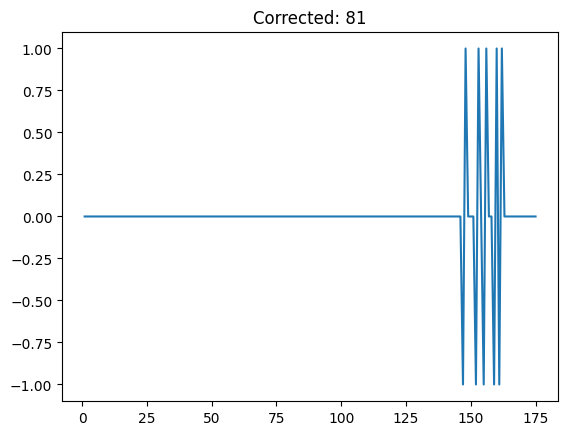

[146, 147, 151, 152, 154, 155, 158, 159, 160, 161]
[[18, -1], [23, -1], [45, -1], [47, -1], [83, -1], [143, 2]]


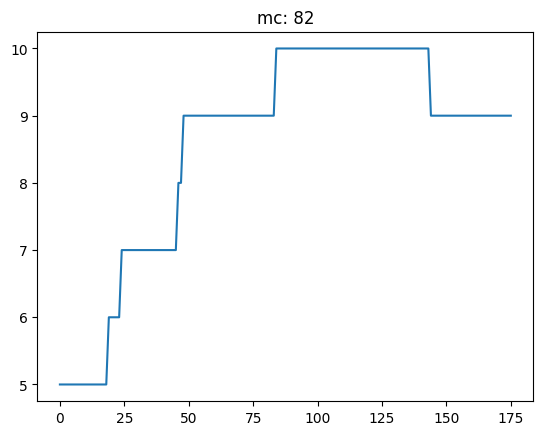

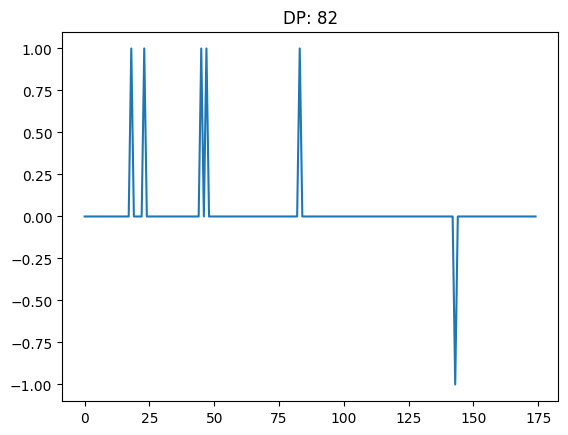

[18, 23, 45, 47, 83, 143]


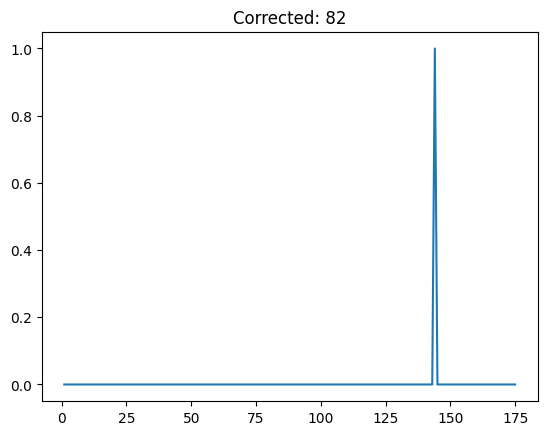

[143]
[[35, -1], [95, 2], [151, 1], [170, 1]]


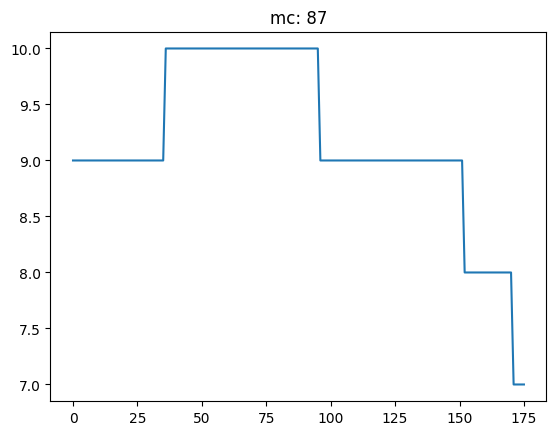

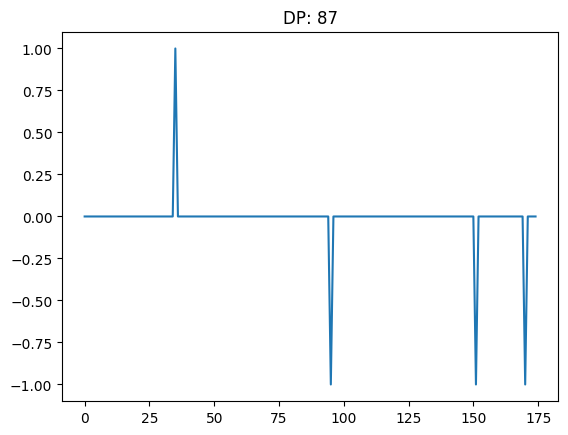

[35, 95, 151, 170]


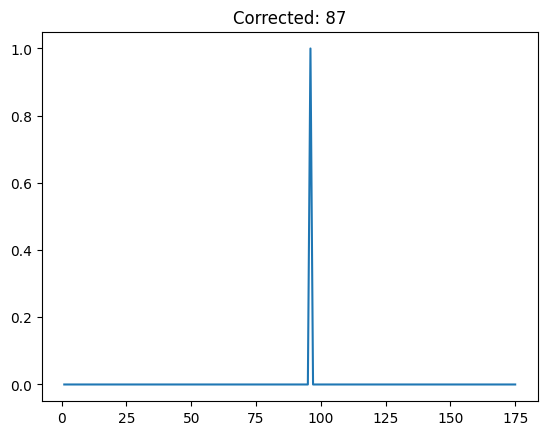

[95]
[[1, -1], [37, -1], [97, 2], [153, 1], [172, 1]]


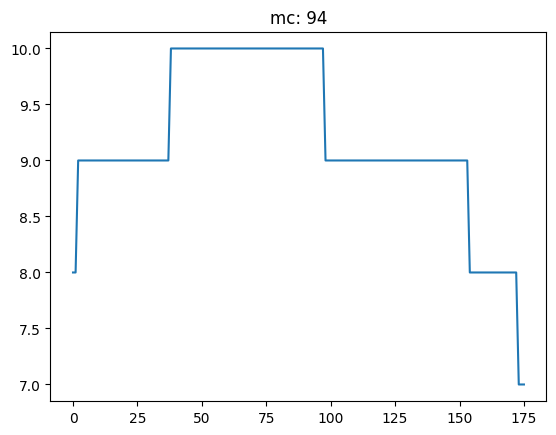

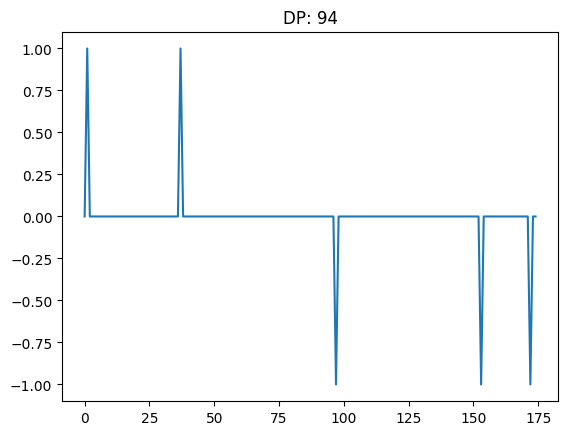

[1, 37, 97, 153, 172]


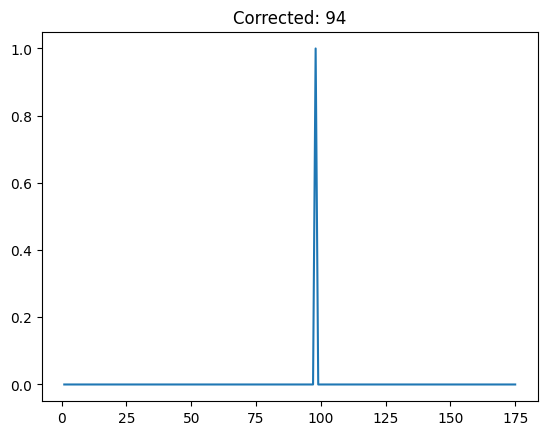

[97]
[[3, -1], [49, 1], [72, -1], [132, 1], [146, 1], [153, 1], [159, -2]]


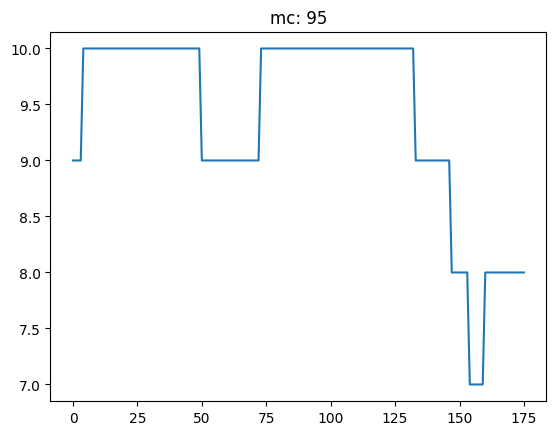

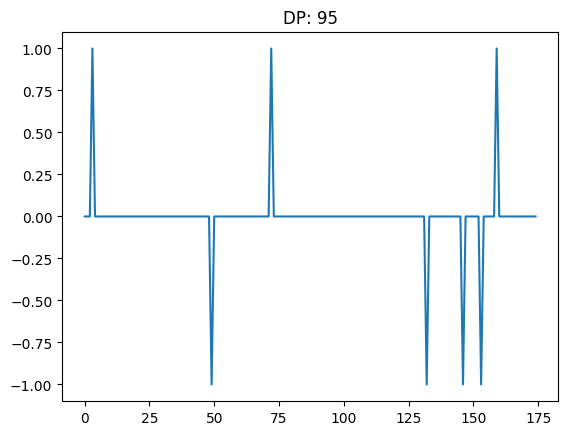

[3, 49, 72, 132, 146, 153, 159]


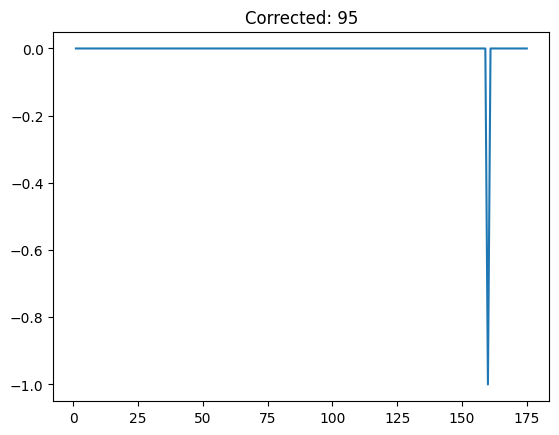

[159]


In [445]:
with open("data/output.txt") as file_in:
    seqs = []
    for line in file_in:
        newline = line.rstrip('\n')
        sequence_chars = [char for char in newline]
        #sequence = parse_nucleotides(sequence_chars)
        seqs.append(sequence_chars)

for i in range(1,len(seqs)):
    # Execute the function we created above on the circular synthetic data.
    # 11110111111011011101010111011011111101111
    # 11111111111101011101010111011011111101111
    # 111111111111111111111111111111111
    # 111111111111101111111111111111111
    # 1111110101110110111101111
    xpoints, ypoints, maxcounts, pc_diff_profile, artifact, mci = correct2("data/output.txt", "1111110101110110111101111", i)
    if not (np.array(ypoints) == np.array([0 for i in range(len(ypoints))])).all():
        print(artifact)
        # Max Counts
        plt.title("mc: "+str(i))
        plt.plot([i for i in range(len(maxcounts))], maxcounts)
        plt.show()
        # DP
        plt.title("DP: "+str(i))
        plt.plot([i for i in range(len(pc_diff_profile))], pc_diff_profile)
        plt.show()
        print([i for i in range(len(pc_diff_profile)) if pc_diff_profile[i]!=0])
        # Corrected DP
        plt.title("Corrected: "+str(i))
        plt.plot(xpoints, ypoints)
        plt.show()
        print([i for i in range(len(ypoints)) if ypoints[i]!=0])
        #break

## SNP in first read of the same data as above

[[23, 1], [25, 1], [43, -1], [64, 1], [66, 1], [83, -1], [91, -1], [95, -1], [96, -1], [110, -1], [116, -1], [122, -1], [156, -1]]


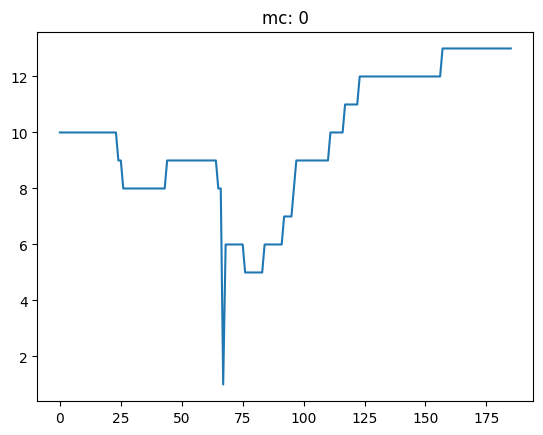

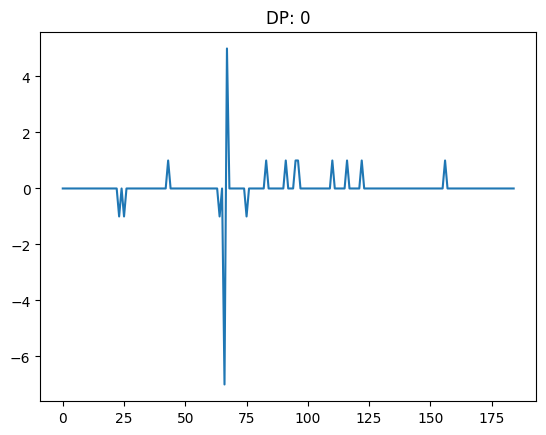

[23, 25, 43, 64, 66, 67, 75, 83, 91, 95, 96, 110, 116, 122, 156]


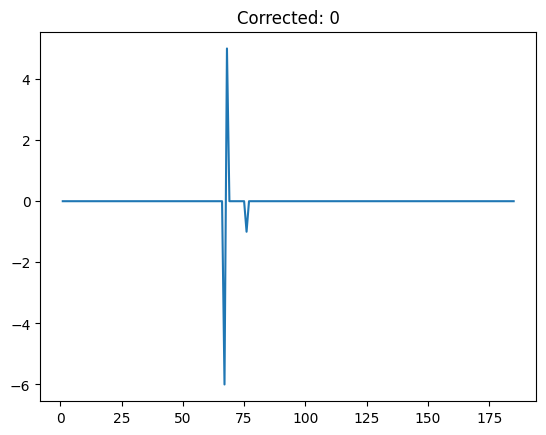

[66, 67, 75]


In [446]:
with open("data/manipulated_output.txt") as file_in:
    seqs = []
    for line in file_in:
        newline = line.rstrip('\n')
        sequence_chars = [char for char in newline]
        #sequence = parse_nucleotides(sequence_chars)
        seqs.append(sequence_chars)

for i in range(len(seqs)):
    # Execute the function we created above on the circular synthetic data.
    # 11110111111011011101010111011011111101111
    # 11111111111101011101010111011011111101111
    # 111111111111111111111111111111111
    # 111111111111101111111111111111111
    xpoints, ypoints, maxcounts, pc_diff_profile, artifact, mci = correct2("data/manipulated_output.txt", "111111010111111", i)
    if not (np.array(ypoints) == np.array([0 for i in range(len(ypoints))])).all():
        print(artifact)
        # Max Counts
        plt.title("mc: "+str(i))
        plt.plot([i for i in range(len(maxcounts))], maxcounts)
        plt.show()
        # DP
        plt.title("DP: "+str(i))
        plt.plot([i for i in range(len(pc_diff_profile))], pc_diff_profile)
        plt.show()
        print([i for i in range(len(pc_diff_profile)) if pc_diff_profile[i]!=0])
        # Corrected DP
        plt.title("Corrected: "+str(i))
        plt.plot(xpoints, ypoints)
        plt.show()
        print([i for i in range(len(ypoints)) if ypoints[i]!=0])
        break
    #break